In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import laplace, norm, uniform

In [2]:
param_files = ["exp_params.txt", "pair_params.txt", "peptide_params.txt"]
params = {}
for pf in param_files:
    pfp = os.path.join("/gd/bayesian_RT/Alignments/SQC_20180815_2", pf)
    #pfp = os.path.join("/Users/albert/git/RTLib/Alignments/NCE_20180520_4", pf)
    if os.path.exists(pfp):
      with open(pfp, "rb") as f:
        try:
          params[pf.split("_")[0]] = pd.read_csv(pfp, sep="\t")
        except:
          print("some error")
params

{'exp':         beta_0    beta_1    beta_2  sigma_intercept  sigma_slope  split_point  \
 0    13.039694  0.652374  0.643696         0.137835     0.110719    34.560044   
 1     5.596057  0.625587  0.769449         0.294159     0.132162    26.757307   
 2     6.803289  0.845530  0.759320         0.281499     0.136232    25.785447   
 3     6.737086  0.850836  0.753809         0.234575     0.127138    25.502208   
 4     7.824703  0.789791  0.508273         0.285859     0.136664    47.522128   
 5     7.826316  0.786502  0.508961         0.291131     0.135268    47.983750   
 6     7.600372  0.790126  0.520268         0.309148     0.142555    47.235676   
 7     7.703628  0.785173  0.514531         0.294178     0.138370    47.916408   
 8     8.128260  0.775402  0.539136         0.275409     0.132695    47.823397   
 9     7.681924  0.783680  0.527687         0.278752     0.134515    47.754887   
 10    7.938614  0.777059  0.526225         0.287173     0.134649    48.201228   
 11    8.

In [3]:
dfa = pd.read_csv('/gd/bayesian_RT/Alignments/SQC_20180815_2/ev_updated.txt', sep='\t', low_memory=False)
dfa

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,muij,pep_new,peptide_id,rt_minus,rt_plus,sigmaij,stan_peptide_id,pep_updated,q-value,prot_fdr
0,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,37.657312,1.078405e-05,0.0,0.042393,0.253234,0.337481,0.0,1.078405e-05,0.000008,1.814580e-08
1,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,37.534676,2.131293e-04,0.0,0.042854,0.278506,0.342226,0.0,2.131293e-04,0.000044,1.814580e-08
2,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,37.445615,1.589575e-05,0.0,0.041090,0.287841,0.362995,0.0,1.589575e-05,0.000008,1.814580e-08
3,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,37.361802,6.185735e-05,0.0,0.041125,0.312588,0.346444,0.0,6.185735e-05,0.000015,1.814580e-08
4,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,37.283701,8.651096e-06,0.0,0.042920,0.264140,0.329562,0.0,8.651096e-06,0.000008,1.814580e-08
5,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,37.290278,1.253275e-05,0.0,0.045281,0.192362,0.338033,0.0,1.253275e-05,0.000008,1.814580e-08
6,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,37.290278,3.111576e-10,0.0,0.045282,0.191615,0.338033,0.0,3.111576e-10,0.000008,1.814580e-08
7,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,37.357579,2.335340e-05,0.0,0.047485,0.217908,0.341680,0.0,2.335340e-05,0.000008,1.814580e-08
8,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.338100e-04,0.000030,1.814580e-08
9,AAAAAAALQAK,11,Unmodified,_AAAAAAALQAK_,NaN,NaN,0,0,0,sp|P36578|RL4_HUMAN60SribosomalproteinL4OS=Hom...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.075300e-05,0.000015,1.814580e-08


In [4]:
dff = dfa[-(dfa["remove"])].reset_index(drop=True)

# factorize experiments into exp_id
#eidx = dff["raw_file"].unique()
#print(len(eidx))
#dff["exp_id"] = dff["raw_file"].map({ind: val for val, ind in enumerate(dff["raw_file"].unique())})

# factorize sequence into peptide_id
#dff["stan_peptide_id"] = dff["sequence"].map({ind: val for val, ind in enumerate(dff["sequence"].unique())})

num_experiments = dff["exp_id"].max() + 1
num_observations = dff.shape[0]
num_peptides = dff["peptide_id"].max() + 1
retention_times = dff["Retention time"]

# cap PEP at 1
dff['PEP'].loc[dff['PEP'] > 1] = 1
dff['pep_new'].loc[dff['pep_new'] > 1] = 1
dff['pep_updated'].loc[dff['pep_updated'] > 1] = 1

pep = dff["PEP"]
stan_peptide_id = dff["peptide_id"]
exp_id = dff["exp_id"]
exp_names = dff['Raw file'].unique()
mean_log_rt = np.mean(np.log(retention_times))
sd_log_rt = np.std(np.log(retention_times))
max_rt = retention_times.max()

pep_exp_all = dff["peptide_id"].map(str) + " - " + dff["exp_id"].map(str)
pep_exp_pairs = pep_exp_all.unique()
num_pep_exp_pairs = len(pep_exp_pairs)
print(len(pep_exp_all))
print(len(pep_exp_all.unique()))
muij_map = pep_exp_all.map({ind: val for val, ind in enumerate(pep_exp_pairs)})
#muij_map
#dff

/Users/albert/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


385966
369774


Generating Summary for Experiment 1 | 180320S_QC_SQC67D8


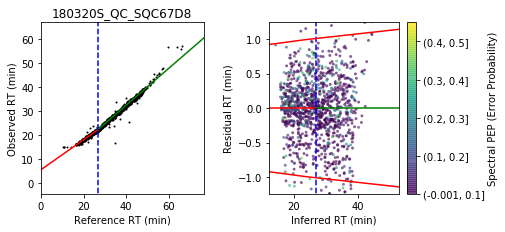

In [36]:
pep_col_code = pd.cut(dff["PEP"], 10)

for exp in range(1,2):
    print("Generating Summary for Experiment", exp, "|", exp_names[exp])

    exp_params = params["exp"].iloc[exp]
    exp_inds = (dff['exp_id'] == exp) & (~pd.isnull(dff['pep_new']))

    predicted = dff['muij'][exp_inds].values
    predicted_sd = dff['sigmaij'][exp_inds].values
    mus = dff['mu'][exp_inds].values

    # observed values
    observed = dff['Retention time'][exp_inds].values
    obs_peps = dff['PEP'][exp_inds].values
    obs_code = pep_col_code[exp_inds].values
    residual = observed - predicted

    plt.subplot(121)
    plt.scatter(mus, observed, s=1, color="black")
    #plt.scatter(predicted, observed)
    plt.plot([0, exp_params["split_point"]],
             [exp_params["beta_0"], (exp_params["split_point"] * exp_params["beta_1"]) + exp_params["beta_0"]],
            color="red")
    plt.plot([exp_params["split_point"], 300], 
             [(exp_params["split_point"] * exp_params["beta_1"]) + exp_params["beta_0"], (exp_params["split_point"] * exp_params["beta_1"]) + ((300-exp_params["split_point"]) * exp_params["beta_2"]) + exp_params["beta_0"]],
            color="green")
    plt.plot(np.repeat(exp_params["split_point"], 2), [-100, 300], color="blue", linestyle="dashed")
    plt.axis([0, mus.max() + 10, exp_params["beta_0"]-10, observed.max() + 10])
    plt.title(exp_names[exp])
    plt.xlabel("Reference RT (min)")
    plt.ylabel("Observed RT (min)")

    plt.subplot(122)
    plt.scatter(predicted, residual, s=4, c=pep_col_code.cat.codes.values[exp_inds], alpha=0.5)
    plt.plot([0, exp_params["split_point"]], [0, 0], color="red")
    plt.plot([exp_params["split_point"], 300], [0, 0], color="green")
    plt.plot(np.repeat(exp_params["split_point"], 2), [-100, 300], color="blue", linestyle="dashed")
    
    # confidence intervals, 2.5% and 97.5%
    conf_x = predicted[np.argsort(predicted)]
    conf_2p5 = laplace.ppf(0.025, loc=0, scale=predicted_sd)[np.argsort(predicted)]
    conf_97p5 = laplace.ppf(0.975, loc=0, scale=predicted_sd)[np.argsort(predicted)]
    
    plt.plot(conf_x, conf_2p5, color="red")
    plt.plot(conf_x, conf_97p5, color="red")
    plt.axis([predicted.min()-5, predicted.max()+5, residual.min()-5, residual.max()+5])
    
    plt.ylim(np.min(conf_2p5) - 0.1, np.max(conf_97p5) + 0.1)
    plt.xlim(conf_x[0], conf_x[-1])
    
    cbar = plt.colorbar()
    cbar.set_label('Spectral PEP (Error Probability)')
    cbar.ax.set_yticklabels(pep_col_code.cat.categories.values)
    plt.xlabel("Inferred RT (min)")
    plt.ylabel("Residual RT (min)")

    plt.subplots_adjust(hspace=0.3, wspace=0.4, bottom=0.2)
#    plt.grid()

    fig = plt.gcf()
    fig.set_size_inches(7, 3.5)
    #fname = "./tmp_figs/alignment_" + str(exp) + "_" + exp_names[exp] + ".png"
    #print("Saving figure to", fname, "...")
    #fig.savefig(fname, dpi=160)
    
    #plt.close()
    #fig.clf()
    
    plt.show()

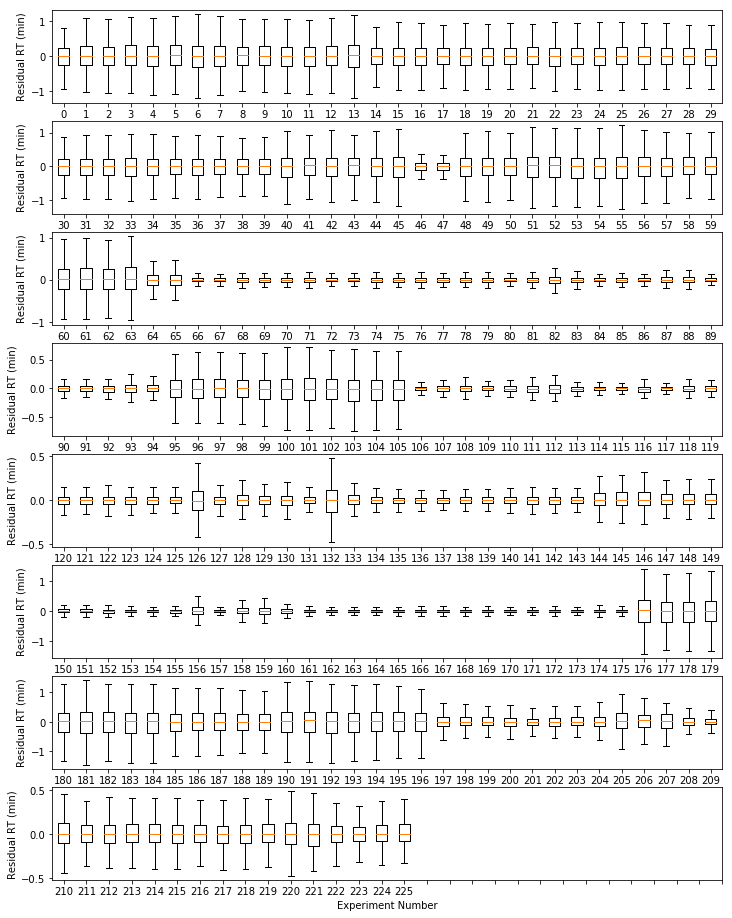

In [41]:
num_experiments = len(dff['exp_id'].unique())
dff['residual'] = dff['Retention time'] - dff['muij']

plots_per_row = 30
if num_experiments < plots_per_row:
    plots_per_row = num_experiments

num_rows = int(np.ceil(num_experiments / plots_per_row))

resi = []

for i in range(0, num_rows):
    ax = plt.subplot2grid((num_rows, 1), (i, 0))

    if (i + 1) * plots_per_row > num_experiments:
        resi = [dff['residual'][(dff['exp_id'] == i) & (~pd.isnull(dff['residual']))] for i in range((i * plots_per_row), num_experiments)]
        ax.boxplot(resi, showfliers=False)
        ax.set_xticklabels(np.arange((i * plots_per_row), num_experiments, 1))
    else:
        resi = [dff['residual'][(dff['exp_id'] == i) & (~pd.isnull(dff['residual']))] for i in range((i * plots_per_row), ((i + 1) * plots_per_row))]
        ax.boxplot(resi, showfliers=False)
        ax.set_xticklabels(np.arange((i * plots_per_row), ((i + 1) * plots_per_row), 1))

    #ax.violinplot(resi, showmedians=True, showextrema=True)
    #ax.boxplot(resi, showfliers=False)
    ax.set_xticks(np.arange(1, plots_per_row + 1, 1))

    ax.set_xlabel('Experiment Number')
    ax.set_ylabel('Residual RT (min)')

#plt.subplots_adjust(hspace=0.6, wspace=0.3)
# plt.tight_layout()

# finalize and save figure
f = plt.gcf()
#f.text(0.5, 0, 'Experiment Number', fontsize=16, ha='center', va='center')
#f.text(0.06, 0.5, 'Residual RT (min)', fontsize=16, ha='center', va='center', rotation='vertical')
f.set_size_inches(12, num_rows * 2)

#fname = os.path.join(figures_path, 'residuals_violin.png')
#logger.info('Saving figure to {} ...'.format(fname))
#f.savefig(fname, dpi=160)
#fig_names.append(fname)

#plt.close()
#f.clf()

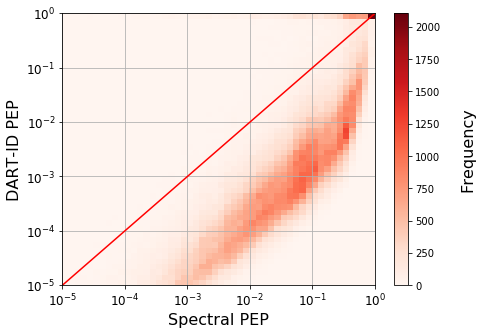

In [17]:
# PEP vs. PEP.new scatterplot
inds = (~pd.isnull(dff['pep_new'])) & (dff['pep_new'] > 1e-5) & (dff['PEP'] > 1e-5)

f, ax = plt.subplots()
hst = ax.hist2d(np.log10(dff['PEP'][inds]), np.log10(dff['pep_new'][inds]), bins=(50, 50), cmap=plt.cm.Reds)
ax.plot([-5, 0], [-5, 0], '-r')

ax.grid()

interval = (-5, 0)
ax.set_xlim(interval)
ax.set_ylim(interval)
ax.set_xlabel('Spectral PEP', fontsize=16)
ax.set_ylabel('DART-ID PEP', fontsize=16)
interval = np.arange(-5, 1, 1)
ax.set_xticks(interval)
ax.set_yticks(interval)
ax.set_xticklabels(['$10^{{{}}}$'.format(i) for i in interval], fontsize=12)
ax.set_yticklabels(['$10^{{{}}}$'.format(i) for i in interval], fontsize=12)

f.set_size_inches(7, 5)
# plt.tight_layout()

cbar = plt.colorbar(hst[3], ax=ax)
cbar.set_label('Frequency', fontsize=16, labelpad=20, ha='center', va='top')
cbar.ax.xaxis.set_label_position('top')

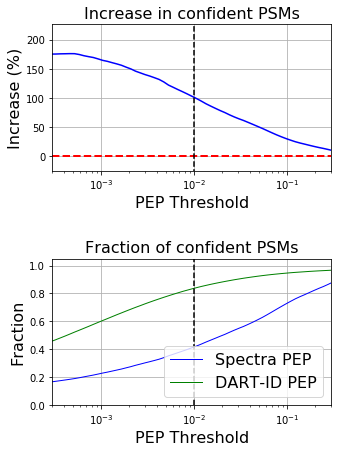

In [12]:
# Fold-change increase
num_points=100
x = np.logspace(-5, 0, num=num_points)
y = np.zeros(num_points)
y2 = np.zeros(num_points)
y3 = np.zeros(num_points)
inds = ~pd.isnull(dff['pep_new'])

for i, j in enumerate(x):
    y[i] = np.sum(dff['pep_updated'] < j) / np.sum(dff['PEP'] < j)
    y2[i] = np.sum(dff['PEP'] < j) / dff.shape[0]
    y3[i] = np.sum(dff['pep_updated'] < j) / dff.shape[0]

f, (ax1, ax2) = plt.subplots(2, 1)

ax1.semilogx(x, (y*100)-100, '-b')
# ax1.plot([np.min(x), np.max(x)], [0, 0], '-r', linestyle='dashed', linewidth=2)
ax1.plot([1e-2, 1e-2], [-1000, 1000], '-k', linestyle='dashed')
ax1.grid()
ax1.set_xlim([3e-4, 3e-1])
ax1.set_ylim([-25, np.max(y)*100-50])
ax1.set_xlabel('PEP Threshold', fontsize=16)
ax1.set_ylabel('Increase (%)', fontsize=16)
ax1.set_title('Increase in confident PSMs', fontsize=16)

ax2.semilogx(x, y2, '-b', linewidth=1, label='Spectra PEP')
ax2.semilogx(x, y3, '-g', linewidth=1, label='DART-ID PEP')
#ax2.fill_between(x, 0, y2)
ax2.plot([1e-2, 1e-2], [-1000, 1000], '-k', linestyle='dashed')
ax2.grid()
ax2.set_xlim([3e-4, 3e-1])
ax2.set_ylim([0, 1.05])
ax2.set_xlabel('PEP Threshold', fontsize=16)
ax2.set_ylabel('Fraction', fontsize=16)
ax2.set_title('Fraction of confident PSMs', fontsize=16)
ax2.legend(fontsize=16)

plt.subplots_adjust(hspace=0.6, wspace=0.3)

f.set_size_inches(5, 7)
# plt.tight_layout()